# Modelo de Tasación Automática de Propiedades Regresión Lineal

## Descripción del Proyecto
Este notebook contiene el flujo de trabajo completo para entrenar un modelo de Machine Learning capaz de estimar el valor de propiedades inmobiliarias (en UF) en la Región Metropolitana de Santiago.



## 1. Entrenamiento Inicial y Evaluación Visual

En esta sección cargamos el dataset procesado (`data_propiedades_loc.csv`). Seleccionamos las variables más relevantes (como superficie, ubicación, antigüedad, etc).

El objetivo es obtener una métrica base ($R^2$) para evaluar qué tan bien se ajusta una regresión lineal simple a los datos.


R2 Entrenamiento: 0.9061216671184982
R2 Prueba: 0.9072240464872544


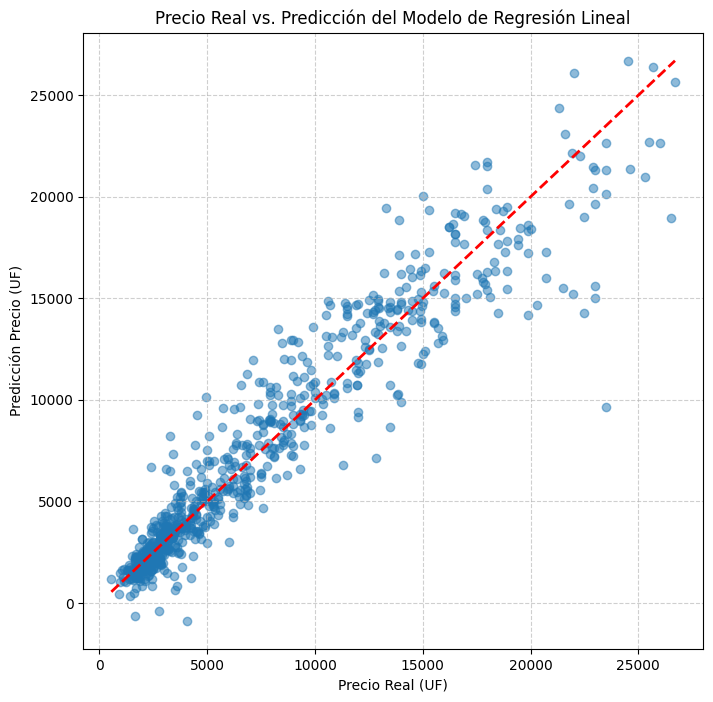

['modelo_tasacion.pkl']

In [12]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")
ruta_del_archivo = "..\\..\\Data\\Procesados\\data_propiedades_loc.csv"
dffff = pd.read_csv(ruta_del_archivo)
dffff = dffff.dropna()
features = ['comuna', 'm2_totales', 'm2_construidos',
       'banos', 'dormitorios', 'antiguedad_anos', 'estacionamientos', 'jardin',
       'piscina', 'quincho', 'condominio_cerrado', 'educacion', 'comercios',
       'salud', 'tipo_vivienda', 'latitud', 'longitud','distancia_centro_km' ]
X_original = dffff[features]
Y = dffff['precio_uf']
X_encoded = pd.get_dummies(X_original, drop_first=True)
x_train, x_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2) 
model = LinearRegression()
model.fit(x_train, y_train)

pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)


print(f"R2 Entrenamiento: {r2_train}")
print(f"R2 Prueba: {r2_test}")

plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Precio Real (UF)")
plt.ylabel("Predicción Precio (UF)")
plt.title("Precio Real vs. Predicción del Modelo de Regresión Lineal")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
dffff.drop(columns=['direccion'], errors='ignore').to_csv("..\\..\\Data\\Procesados\\data_propiedades_loc.csv", index=False)
joblib.dump(model, "modelo_tasacion.pkl")



Para mejorar la robustez del modelo, realizaremos las siguientes mejoras:

1.  **Cálculo de Distancia al Centro:** Creamos una nueva variable numérica calculando la distancia desde la latitud/longitud de la propiedad hasta el centro de Santiago. 

2.  **Estandarización (`StandardScaler`):** Normalizamos las variables numéricas para que tengan media 0 y desviación estándar 1, para evitar que variables con magnitudes grandes (ej. precios) dominen sobre las pequeñas (ej. número de baños).


### programa simple ###


### Funciones de Tasación

A continuación, definimos dos funciones clave:

* `predecir_precio(inputs)`: Se encarga del trabajo sucio. Recibe los datos crudos, calcula la distancia geospacial, aplica el mismo `StandardScaler` entrenado y formatea el dataframe para que coincida con el modelo.
* `tasar_propiedad(...)`: Es una interfaz amigable para el usuario final. Permite ingresar los datos de una casa o departamento y devuelve el valor estimado en UF.

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


ruta_del_archivo = "..\\..\\Data\\Procesados\\data_propiedades_loc.csv"
dffff = pd.read_csv(ruta_del_archivo)
features_categoricas = ['comuna', 'tipo_vivienda']
features_numericas = ['m2_totales', 'm2_construidos', 'banos', 'dormitorios', 'antiguedad_anos', 'estacionamientos', 'latitud', 'longitud', 'distancia_centro_km']
features_booleanas = ['jardin', 'piscina', 'quincho', 'condominio_cerrado', 'educacion', 'comercios', 'salud']
features = features_categoricas + features_numericas + features_booleanas

X_original = dffff[features]
Y = dffff['precio_uf']

def calcular_distancia(lat1, lon1, lat2, lon2):
    R = 6371
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = (np.sin(dlat/2) * np.sin(dlat/2) + 
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * 
         np.sin(dlon/2) * np.sin(dlon/2))
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

CENTRO_LAT = -33.4395
CENTRO_LON = -70.6347
X_encoded = pd.get_dummies(X_original, drop_first=True)
columnas_entrenamiento = X_encoded.columns.tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2)

model = LinearRegression()
model.fit(x_train, y_train)

pred_test = model.predict(x_test)
r2_test = r2_score(y_test, pred_test)

print(f"R² Modelo General: {r2_test:.4f}")

joblib.dump(model, "modelo_tasacion.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(columnas_entrenamiento, "columnas_entrenamiento.pkl")


def predecir_precio(inputs):
    """Función de predicción mejorada"""
    model = joblib.load("modelo_tasacion.pkl")
    scaler = joblib.load("scaler.pkl")
    columnas_entrenamiento = joblib.load("columnas_entrenamiento.pkl")
    
    distancia = calcular_distancia(
        inputs['latitud'], inputs['longitud'],
        CENTRO_LAT, CENTRO_LON
    )
    
    input_data = {}
    for feature in features:
        if feature == 'distancia_centro_km':
            input_data[feature] = distancia
        elif feature in features_numericas:
            input_data[feature] = float(inputs[feature])
        elif feature in features_booleanas:
            input_data[feature] = int(inputs[feature])
        else:
            input_data[feature] = inputs[feature]
    
    input_df = pd.DataFrame([input_data])
    input_encoded = pd.get_dummies(input_df, drop_first=True)
    
    input_final = pd.DataFrame(columns=columnas_entrenamiento)
    for col in input_encoded.columns:
        if col in input_final.columns:
            input_final[col] = input_encoded[col]
    
    input_final = input_final.fillna(0)
    input_scaled = scaler.transform(input_final)
    
    prediccion = model.predict(input_scaled)
    prediccion_ajustada = max(prediccion[0], Y.min()) 
    
    return prediccion_ajustada, distancia

def tasar_propiedad(comuna, tipo_vivienda, m2_totales, m2_construidos, dormitorios, banos, 
                   antiguedad_anos, estacionamientos, latitud, longitud,
                   jardin=0, piscina=0, quincho=0, condominio_cerrado=0,
                   educacion=0, comercios=0, salud=0):
    inputs = {'comuna': comuna,
        'tipo_vivienda': tipo_vivienda, 
        'm2_totales': m2_totales,
        'm2_construidos': m2_construidos,
        'dormitorios': dormitorios,
        'banos': banos,
        'antiguedad_anos': antiguedad_anos,
        'estacionamientos': estacionamientos,
        'jardin': jardin,
        'piscina': piscina,
        'quincho': quincho,
        'condominio_cerrado': condominio_cerrado,
        'educacion': educacion,
        'comercios': comercios,
        'salud': salud,
        'latitud': latitud,
        'longitud': longitud}
    precio, distancia = predecir_precio(inputs)
    return precio

precio1 = tasar_propiedad(
    comuna='Santiago',
    tipo_vivienda='Departamento', 
    m2_totales=138,
    m2_construidos=138,
    dormitorios=3,
    banos=3,
    antiguedad_anos=66,
    estacionamientos=1,
    latitud=-33.4372,
    longitud=-70.6506,
    jardin=0,
    piscina=0,
    quincho=0,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)

precio2 = tasar_propiedad(
    comuna='La Florida',
    tipo_vivienda='Casa',
    m2_totales=180,
    m2_construidos=68, 
    dormitorios=3,
    banos=2,
    antiguedad_anos=42,
    estacionamientos=1,
    latitud=-33.55597789358166,
    longitud=-70.5753024310111,
    jardin=1,
    piscina=0,
    quincho=0,
    condominio_cerrado=0,
    educacion=1,
    comercios=1,
    salud=1
)

precio3 = tasar_propiedad(
    comuna='Puente Alto',
    tipo_vivienda='Casa',
    m2_totales=247,
    m2_construidos=82,
    dormitorios=3,
    banos=2,
    antiguedad_anos=21,
    estacionamientos=1,
    latitud=-33.6112,
    longitud=-70.5756,
    jardin=0,
    piscina=0,
    quincho=0,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)
precio4 = tasar_propiedad(
    comuna='La Florida',
    tipo_vivienda='Casa',
    m2_totales=197,
    m2_construidos=129,
    dormitorios=3,
    banos=2,
    antiguedad_anos=29,
    estacionamientos=2,
    latitud=-33.542061785785414,
    longitud=-70.56262583286126,
    jardin=1,
    piscina=0,
    quincho=0,
    condominio_cerrado=0,
    educacion=1,
    comercios=1,
    salud=1
)
precio5 = tasar_propiedad(
    comuna='Huechuraba',
    tipo_vivienda='Casa',
    m2_totales=224,
    m2_construidos=107,
    dormitorios=3,
    banos=3,
    antiguedad_anos=15,
    estacionamientos=2,
    latitud=-33.360621919127254, 
    longitud=-70.67496054087297,
    jardin=1,
    piscina=0,
    quincho=0,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)
precio6 = tasar_propiedad(
    comuna='Maipu',
    tipo_vivienda='Casa',
    m2_totales=141,
    m2_construidos=125,
    dormitorios=2,
    banos=2,
    antiguedad_anos=14,
    estacionamientos=1,
    latitud=-33.547673339614114,
    longitud=-70.79238664820353,
    jardin=1,
    piscina=0,
    quincho=0,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)

print(f"\n{'='*60}")
print("COMPARATIVA CON PRECIOS REALES")

if precio1:
    print(f"Departamento Santiago: {precio1:,.0f} UF (Real: 7,482 UF) ")
if precio2:
    print(f"Casa La Florida: {precio2:,.0f} UF (Real: 2,750 UF)")
if precio3:
    print(f"Casa Puente Alto: {precio3:,.0f} UF (Esperado: 3,814-4,875 UF)")
if precio4:
    print(f"Casa La florida 2: {precio4:,.0f} UF (Esperado: 5575 UF)")
if precio5:
    print(f"Casa huechuraba: {precio5:,.0f} UF (Esperado: 5474 UF)")
if precio6:
    print(f"Casa maipu: {precio6:,.0f} UF (Esperado: 4354 UF)")
print(f"\n{'='*60}")

print(f"\n{'='*60}")
print("PRUEBAS DE ESTRÉS: DEPARTAMENTOS (Detectando sesgos del modelo)")
print(f"{'='*60}\n")



R² Modelo General: 0.9110

COMPARATIVA CON PRECIOS REALES
Departamento Santiago: 4,585 UF (Real: 7,482 UF) 
Casa La Florida: 2,631 UF (Real: 2,750 UF)
Casa Puente Alto: 3,854 UF (Esperado: 3,814-4,875 UF)
Casa La florida 2: 5,106 UF (Esperado: 5575 UF)
Casa huechuraba: 5,333 UF (Esperado: 5474 UF)
Casa maipu: 4,716 UF (Esperado: 4354 UF)


PRUEBAS DE ESTRÉS: DEPARTAMENTOS (Detectando sesgos del modelo)



In [14]:


precio_depto_las_condes = tasar_propiedad(
    comuna='Las Condes',
    tipo_vivienda='Departamento',
    m2_totales=140,
    m2_construidos=130,
    dormitorios=3,
    banos=3,
    antiguedad_anos=10,
    estacionamientos=2,
    latitud=-33.4125,
    longitud=-70.5824,  
    jardin=0,
    piscina=1,
    quincho=1,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)

precio_depto_providencia = tasar_propiedad(
    comuna='Providencia',
    tipo_vivienda='Departamento',
    m2_totales=95,
    m2_construidos=90,
    dormitorios=2,
    banos=2,
    antiguedad_anos=40,
    estacionamientos=1,
    latitud=-33.4346,
    longitud=-70.6149,
    jardin=0,
    piscina=0,
    quincho=0,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)


precio_depto_nunoa = tasar_propiedad(
    comuna='Nunoa',
    tipo_vivienda='Departamento',
    m2_totales=65,
    m2_construidos=60,
    dormitorios=2,
    banos=2,
    antiguedad_anos=5,
    estacionamientos=1,
    latitud=-33.4539,
    longitud=-70.5928,
    jardin=0,
    piscina=1,
    quincho=1,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)


precio_depto_san_miguel = tasar_propiedad(
    comuna='San Miguel',
    tipo_vivienda='Departamento',
    m2_totales=45,
    m2_construidos=42,
    dormitorios=1,
    banos=1,
    antiguedad_anos=2,
    estacionamientos=0,
    latitud=-33.4922,
    longitud=-70.6521,
    jardin=0,
    piscina=1,
    quincho=1,
    condominio_cerrado=1,
    educacion=1,
    comercios=1,
    salud=1
)

# --- IMPRESIÓN DE RESULTADOS PARA ANÁLISIS ---

if precio_depto_las_condes:
    # Valor Mercado Aprox: 11.000 - 13.000 UF
    print(f"1. Las Condes (Lujo): {precio_depto_las_condes:,.0f} UF (Ref Mercado: ~12.000 UF)")

if precio_depto_providencia:
    # Valor Mercado Aprox: 6.500 - 7.500 UF
    print(f"2. Providencia (Clásico): {precio_depto_providencia:,.0f} UF (Ref Mercado: ~7.000 UF)")

if precio_depto_nunoa:
    # Valor Mercado Aprox: 4.500 - 5.500 UF
    print(f"3. Ñuñoa (Moderno): {precio_depto_nunoa:,.0f} UF (Ref Mercado: ~5.000 UF)")

if precio_depto_san_miguel:
    # Valor Mercado Aprox: 2.800 - 3.200 UF
    print(f"4. San Miguel (Inversión): {precio_depto_san_miguel:,.0f} UF (Ref Mercado: ~3.000 UF)")

print()
print("NOTA: Si los valores predichos son consistentemente más bajos que la referencia de mercado,")
print("se confirma que el modelo penaliza excesivamente la variable 'Departamento'.")

1. Las Condes (Lujo): 6,042 UF (Ref Mercado: ~12.000 UF)
2. Providencia (Clásico): 2,847 UF (Ref Mercado: ~7.000 UF)
3. Ñuñoa (Moderno): 2,808 UF (Ref Mercado: ~5.000 UF)
4. San Miguel (Inversión): 1,581 UF (Ref Mercado: ~3.000 UF)

NOTA: Si los valores predichos son consistentemente más bajos que la referencia de mercado,
se confirma que el modelo penaliza excesivamente la variable 'Departamento'.


##  Análisis de Resultados de las Pruebas

Al probar el modelo con propiedades específicas (casos reales vs. estimaciones), hemos detectado un comportamiento diferenciado según el tipo de vivienda:

* **Precisión General:** El modelo mantiene un $R^2$ cercano a **0.89**. Sin embargo, esta métrica general esconde un sesgo importante entre casas y departamentos.

* **Diferencia por Tipo de Vivienda:**
    * **Casas (Modelo Ajustado):** En zonas residenciales tradicionales (ej. La Florida, Puente Alto, Maipú), el modelo predice con alta exactitud. La relación entre m2, terreno y precio se comporta de manera lineal y predecible en este segmento.
    * **Departamentos (Subestimación):** Existe una **subestimación sistemática** en los precios de los departamentos.
    
* **Diagnóstico del Problema:**
    Al ser una **Regresión Lineal**, el modelo penaliza fuertemente a los departamentos por tener menor superficie (`m2_totales` y `m2_construidos`) en comparación a las casas. El modelo no está logrando capturar que el "precio por m2" de un departamento en zona céntrica es mucho más alto que el de una casa en la periferia.

**Solución**
**Separar Modelos:** Entrenar un modelo exclusivo para Casas y otro para Departamentos podría eliminar este sesgo.
